In [0]:
# import the necessary packages
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

In [3]:
# All images will be rescaled by 1./255  ===> data normalization  
train_datagen = ImageDataGenerator(# Augmentation parameters:
                                   preprocessing_function = preprocess_input, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator( preprocessing_function = preprocess_input)

# Flow training images in batches of 128 using train_datagen generator
'''
What does flow_from_directory give you on the ImageGenerator?
- The ability to easily load images for training
- The ability to pick the size of training images
- The ability to automatically label images based on their directory name
'''
# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(
        '/content/dataset/train/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=64,  # Integer or None. Number of samples per gradient update. 
                        # If unspecified, batch_size will default to 32.
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory('/content/dataset/test/',
                                                         batch_size=32,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))


print("training set classes: ", train_generator.class_indices)
print("testing set classes", validation_generator.class_indices)

print(validation_generator.labels)

Found 1174 images belonging to 2 classes.
Found 264 images belonging to 2 classes.
training set classes:  {'with_mask': 0, 'without_mask': 1}
testing set classes {'with_mask': 0, 'without_mask': 1}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [5]:
baseModel.trainable = False

model = Sequential()
model.add(baseModel)
model.add(AveragePooling2D(pool_size=(5, 5)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
________________________________________

In [0]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])


In [7]:

history = model.fit_generator(
      train_generator,
    
      steps_per_epoch= 19, # Total number of steps (batches of samples) before declaring one epoch finished 
                           # and starting the next epoch.  
    
      epochs=20,  # Integer. Number of epochs to train the model. 
                  # An epoch is an iteration over the entire data provided. 
    
      verbose=1,  # Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
      validation_data=validation_generator, # Data on which to evaluate the loss and any model metrics at

      validation_steps = 9
      
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
19/19 [==============================] - 60s 3s/step - loss: 0.1136 - accuracy: 0.9497 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 2/20
19/19 [==============================] - 58s 3s/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 7.8592e-04 - val_accuracy: 1.0000
Epoch 3/20
19/19 [==============================] - 58s 3s/step - loss: 0.0197 - accuracy: 0.9940 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/20
19/19 [==============================] - 57s 3s/step - loss: 0.0156 - accuracy: 0.9923 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/20
19/19 [==============================] - 57s 3s/step - loss: 0.0198 - accuracy: 0.9966 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/20
19/19 [==============================] - 57s 3s/step - loss: 0.0330 - accuracy: 0.9889 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 7/20
19/19 [==============================] - 57s 3s/step - loss: 0.0172 -

In [0]:
# Saving our model
model.save('face_mask_model.h5')

Text(0.5, 1.0, 'Training and validation loss')

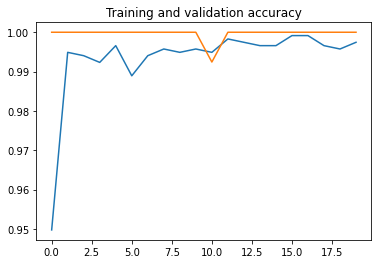

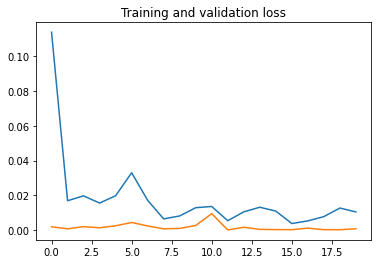

In [8]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )


In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/51.jpg', target_size = (224, 224)) 
test_image = image.img_to_array(test_image)
test_image = preprocess_input(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)


print("the cat.:",result[0][0])

if result[0][0] < 0.5:
    prediction = 'with_mask'
else:
    prediction = 'without_mask'

prediction


the cat.: 1.0


'without_mask'